# Bunny Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, GATKernel
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.score import ScoreDensity
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, \
    project_pdf_to_mesh

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [8]:
key = jax.random.PRNGKey(0)

## Data

In [11]:
bunny_o3d = o3d.data.BunnyMesh()
bunny = o3d_mesh_to_pv(bunny_o3d)
# bunny_small = downsample_o3d_mesh(bunny_o3d, (32,))
# bunny_graph = o3d_mesh_to_graph(bunny_small)

bunny_bounds = bunny.bounds
bunny_bounds = jnp.array(bunny_bounds).reshape(3, 2).T
bounds = bunny_bounds * 1.25

Apply gaussians to the surface of the bunny, projecting to a 2d surface:

In [10]:
# bounds = jnp.array([
#     [-0.15, -0.1, -0.15],
#     [0.1, 0.25, 0.2]
# ])

uni_pdf = lambda x: 1 / x.shape[0]

X_grid = grid(bounds, N=50, flatten=False)
X_flat = grid(bounds, N=50)

n_samples = 3000
samples = jax.random.choice(key, bunny_graph.nodes, shape=(n_samples,), replace=False)
prob_s = jnp.ones(n_samples) / n_samples

n_traj = 300
# traj_init = jnp.linspace(bounds[0], bounds[1], num=n_traj, endpoint=True)
traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)

In [11]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

point_in_mesh_approx = point_in_mesh_fn(bunny, 60, bounds=bounds)

def aux_loss_fn(particles, beta=1.):
    traj_loss = traj_loss_fn(particles)
    clipping_loss = point_in_mesh_approx(particles).mean() * beta
    return traj_loss + clipping_loss

In [12]:
def point_in_mesh_true(particles):
    points = pv.PointSet(particles)
    distances = points.compute_implicit_distance(bunny)["implicit_distance"]
    return jnp.array(distances)

### Initial Metric and Plots

In [15]:
pdf_recon_init = ergodic_metric(traj_init, bounds, n_modes=10, n_per_dim=50)
# pdf_recon_init = pdf_recon_init / jnp.sum(pdf_recon_init)
pdf_true = jax.vmap(uni_pdf)(X_flat)
print(f"Initial ergodic metric: {jnp.mean((pdf_recon_init - pdf_true)**2)}")

Initial ergodic metric: 1532782.6421481844


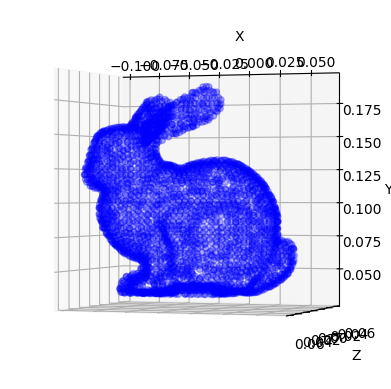

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.view_init(70, 0, 90)
ax.scatter(samples[:, 0], samples[:, 1], samples[:,2], c='b', marker='o', alpha=0.3)

# # Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

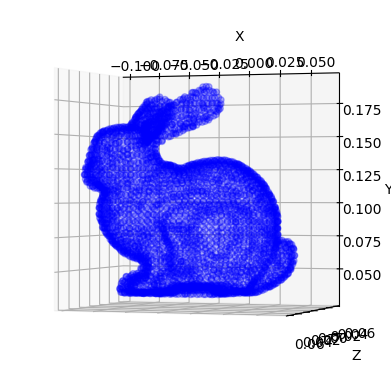

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.view_init(70, 0, 90)
ax.scatter(
    bunny_graph.nodes[:, 0], 
    bunny_graph.nodes[:, 1], 
    bunny_graph.nodes[:,2], 
    c='b', marker='o', alpha=0.3
)

# # Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

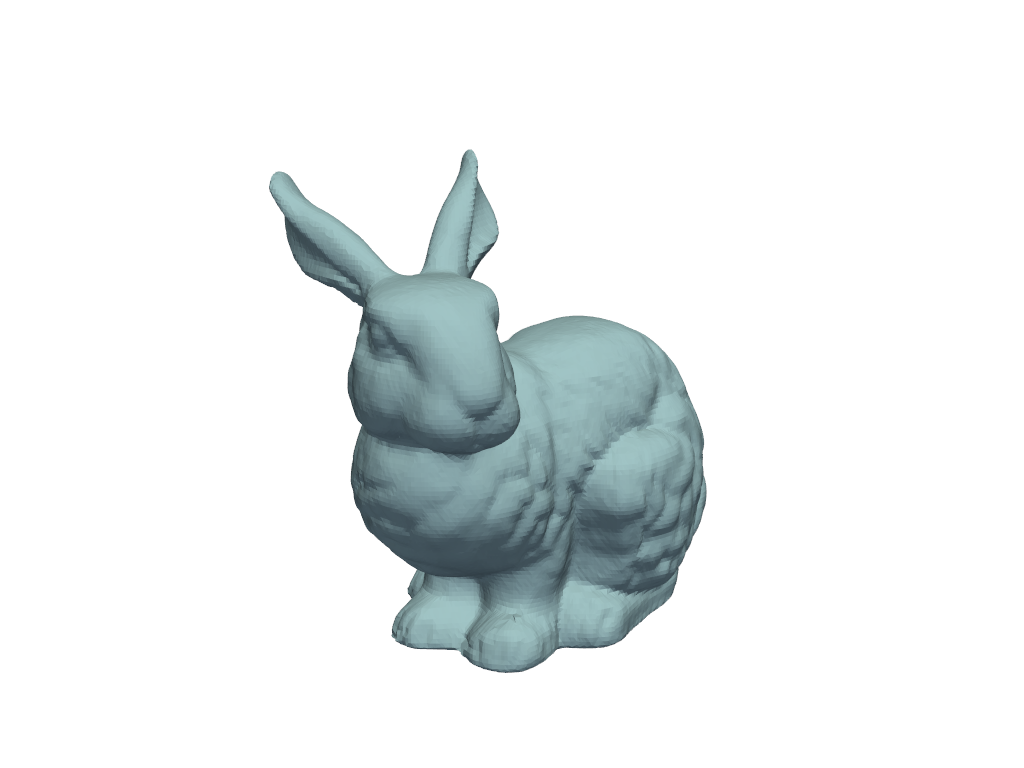

In [18]:
traj_init_points = pv.PointSet(traj_init)

pl = pv.Plotter(notebook=True)
pl.add_mesh(bunny, show_edges=False)
# pl.add_points(traj_init_points, color='r', point_size=10)
pl.camera.roll = 0
pl.camera.elevation = -20
pl.camera.azimuth = 270
pl.show(jupyter_backend='pythreejs')

## Model Definitions

In [17]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [315]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z #, t.q_params, t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [357]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_hidden", 2)
    d_hidden = kwargs.get("d_hidden", 32)
    d_out = kwargs.get("d_out", 8)
    k_init = DeepCK(key, (3, d_out), d_hidden=d_hidden, n_hidden=n_hidden)
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    training_param_fn = lambda t: [
        t.k.nnk.transform, t.k.ck.transform.scale, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # # gp training
    # print("Training gp")
    # mmd_gp, gp_loss = train_mmd_kernel_gp(
    #     key, mmd_init, samples, prob_samples, 
    #     to_train=training_param_fn, 
    #     lowrank=False, **gp_params
    # )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.nnk.transform, t.k.ck.transform.scale, t.k.epsilon, t.z #, t.q_params, t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_score
    # return mmd_init, mmd_power, mmd_gp, mmd_score


In [23]:
def train_graph_kernels(
    key, traj_graph, samples_graph, score_params,
    **kwargs
):
    traj_init = traj_graph.nodes
    samples = samples_graph.nodes
    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.pop("R", 100)
    n_layers = kwargs.pop("n_layers", 3)
    d_hidden = kwargs.pop("d_hidden", 64)
    out_dim = kwargs.pop("out_dim", 10)
    dropout = kwargs.pop("dropout", 0.3)
    n_heads = kwargs.pop("n_heads", 4)
    epsilon = kwargs.pop("epsilon", 0.2)
    
    k_init = GATKernel(
        key, d, out_dim, d_hidden=d_hidden, n_layers=n_layers, 
        dropout=dropout, n_heads=n_heads, ls=ls_init, epsilon=epsilon
    )
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.gat, t.k.ck.transform.scale, t.k.epsilon, t.z #, t.q_params, t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_score


In [354]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [318]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [319]:
rbf_power_params = {
    'epochs': epochs_k, 'lr': lr, 'verbose': False
}
rbf_gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': False
}
rbf_score_params = {
    'lr': 1e-2, 'q': 'uniform', 'q_params': bounds,
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

In [212]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
Training gp
Training score
epoch 0,loss: -174.18299865722656
epoch 50,loss: -76.50865173339844
epoch 100,loss: -71.25334930419922
epoch 150,loss: -204.12173461914062
epoch 200,loss: -13.200944900512695
epoch 250,loss: -20.07374382019043
epoch 300,loss: -123.53597259521484
epoch 350,loss: -56.527099609375
epoch 400,loss: -127.95574188232422
epoch 450,loss: -124.12374877929688
epoch 500,loss: -13.961748123168945
epoch 550,loss: -188.63604736328125
epoch 600,loss: -117.16459655761719
epoch 650,loss: -148.57437133789062
epoch 700,loss: -126.29193115234375
epoch 750,loss: -137.23143005371094
epoch 800,loss: 7.194645881652832
epoch 850,loss: -42.7530403137207
epoch 900,loss: -105.87786102294922
epoch 950,loss: -125.58277130126953
epoch 1000,loss: 29.869285583496094
epoch 1050,loss: -201.46246337890625
epoch 1100,loss: -122.9520263671875
epoch 1150,loss: -39.71098709106445
epoch 1200,loss: -168.9803924560547
epoch 1250,loss: -149.21986389160156
epoch 1300,loss: -72.968315124511

In [340]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.04080058 0.0422663  0.02874909]
Scale: [0.03411498 0.01645072 0.00181439]
Scale: [0.1613693  0.1715551  0.11513659]
Scale: [0.15294343 0.19583118 0.00397218]


Train trajectories with MMD:

In [345]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds,
        solver_params={'tol': 1e-4, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 1000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (rbf_traj_init.w, rbf_power_traj.w, rbf_gp_traj.w, rbf_score_traj.w)

Training model 1
{'tol': 0.0001, 'maxiter': 1000}
Training model 2
{'tol': 0.0001, 'maxiter': 1000}
Training model 3
{'tol': 0.0001, 'maxiter': 1000}
Training model 4
{'tol': 0.0001, 'maxiter': 1000}


### RFF

In [342]:
rff_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': True
}
rff_gp_params = {
    "epochs": 3000, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-2, 'q': 'uniform', 'q_params': bounds,
    'epochs': 3000, 'verbose': True
}

In [343]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples, prob_s, bounds, rff_power_params, rff_gp_params, rff_score_params
)

Training power
epoch 0,loss: -0.13184449288235084
epoch 50,loss: -0.06637608591713444
epoch 100,loss: -0.0034242970495431003
epoch 150,loss: 0.05284276718175244
epoch 200,loss: 0.09602380640828892
epoch 250,loss: 0.12743449832022402
epoch 300,loss: 0.1506007733331685
epoch 350,loss: 0.1684186638504422
epoch 400,loss: 0.18274180736443757
epoch 450,loss: 0.19468425555118063
epoch 500,loss: 0.20486467848298606
epoch 550,loss: 0.21358047663897328
epoch 600,loss: 0.2210065671485103
epoch 650,loss: 0.22731545834203334
epoch 700,loss: 0.23266182683675535
epoch 750,loss: 0.23716752430231713
epoch 800,loss: 0.24095398775680757
epoch 850,loss: 0.24415677083398135
epoch 900,loss: 0.24690597978128315
epoch 950,loss: 0.24931247322013608
epoch 1000,loss: 0.2514699814502417
epoch 1050,loss: 0.2534101536487491
epoch 1100,loss: 0.25509106668434456
epoch 1150,loss: 0.2565380563482668
epoch 1200,loss: 0.25776316050536335
epoch 1250,loss: 0.2587617259493405
epoch 1300,loss: 0.25961096296722136
epoch 1350,

In [344]:
rff_models = (rff_init, rff_power, rff_gp, rff_score)

In [348]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-4, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 5000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (rff_traj_init.w, rff_power_traj.w, rff_gp_traj.w, rff_score_traj.w)

Training model 1
{'tol': 0.0001, 'maxiter': 1000}
Training model 2
{'tol': 0.0001, 'maxiter': 1000}
Training model 3
{'tol': 0.0001, 'maxiter': 1000}
Training model 4
{'tol': 0.0001, 'maxiter': 1000}


### Deep Kernel

In [358]:
deep_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': True
}
deep_gp_params = {
    "epochs": 1000, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
deep_score_params = {
    'lr': 1e-2, 'q': 'uniform', 'q_params': bounds,
    'epochs': 3000, 'verbose': True
}

In [359]:
# deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
#     key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
# )
deep_init, deep_power, deep_score = train_deep_kernels(
    key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_score)

Training power
epoch 0,loss: -0.1546648589716168
epoch 50,loss: -0.03108586232902273
epoch 100,loss: 0.09650859077961056
epoch 150,loss: 0.11852507555870187
epoch 200,loss: 0.1275339411628664
epoch 250,loss: 0.13566333703886344
epoch 300,loss: 0.14665255906708882
epoch 350,loss: 0.16618468778862866
epoch 400,loss: 0.20270127078076117
epoch 450,loss: 0.2609075407761411
epoch 500,loss: 0.29490799241753035
epoch 550,loss: 0.31379489522657905
epoch 600,loss: 0.32600326579409317
epoch 650,loss: 0.33204181136716215
epoch 700,loss: 0.3362172805125222
epoch 750,loss: 0.33934993027328797
epoch 800,loss: 0.34219566290383785
epoch 850,loss: 0.34474042049645504
epoch 900,loss: 0.3530736502034104
epoch 950,loss: 0.35533146508949454
epoch 1000,loss: 0.35710012385629364
epoch 1050,loss: 0.3583579977177105
epoch 1100,loss: 0.35951869946596554
epoch 1150,loss: 0.3604812849566137
epoch 1200,loss: 0.36119325329123697
epoch 1250,loss: 0.3620149649303093
epoch 1300,loss: 0.39722077781501564
epoch 1350,loss

In [364]:
deep_traj_init, deep_power_traj, deep_score_traj = train_trajectories(
        key, deep_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-4, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
deep_trajectories = (rff_traj_init.w, deep_power_traj.w, deep_score_traj.w)

Training model 1
{'tol': 0.0001, 'maxiter': 1000}
Training model 2
{'tol': 0.0001, 'maxiter': 1000}
Training model 3
{'tol': 0.0001, 'maxiter': 1000}


## Visualize

In [362]:
bunny_camera = {"roll": 0, "elevation": -20, "azimuth": -60}

### RBF

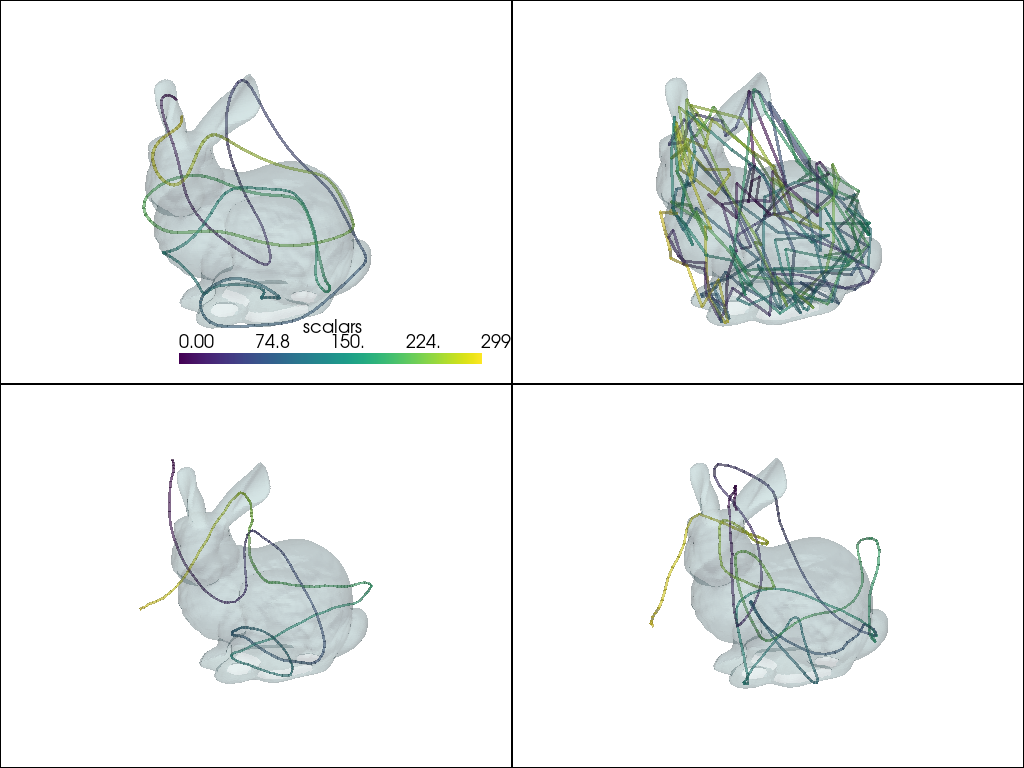

In [347]:
plot_multi_3d_traj_pv(bunny, rbf_trajectories, shape=(2,2), camera_pos=bunny_camera, color=True)

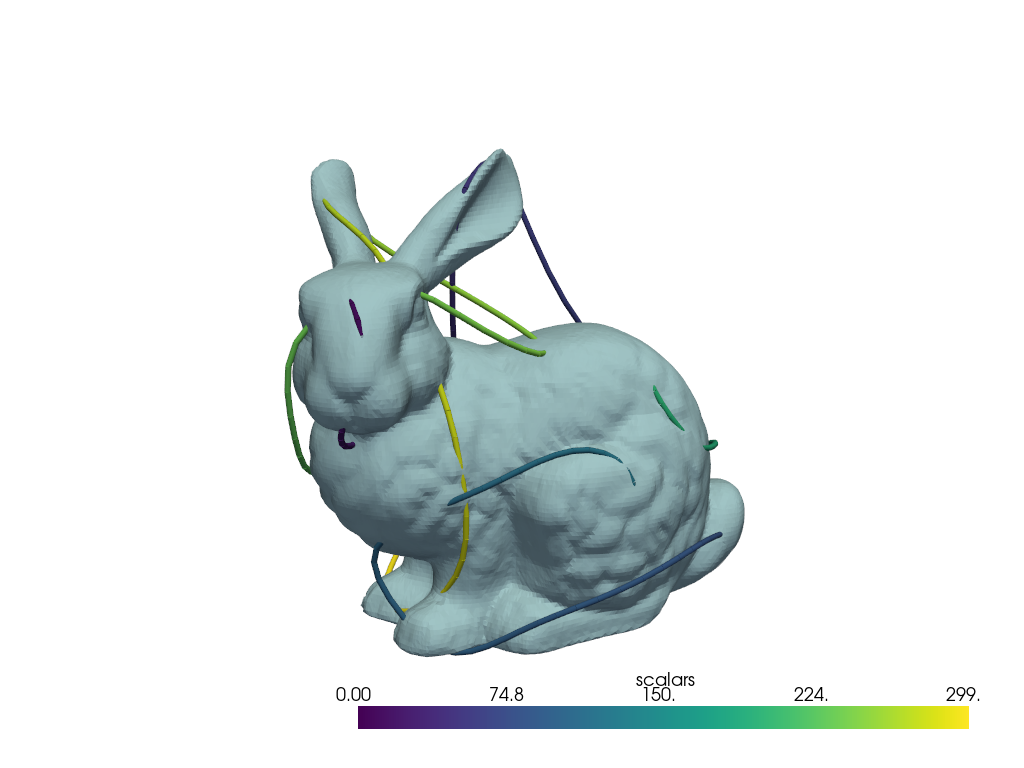

In [220]:
# camera_pos=bunny_camera
plot_3d_trajectory_pv(bunny, rbf_traj_init.w, camera_pos=bunny_camera, color=True, opacity=1)

### RFF

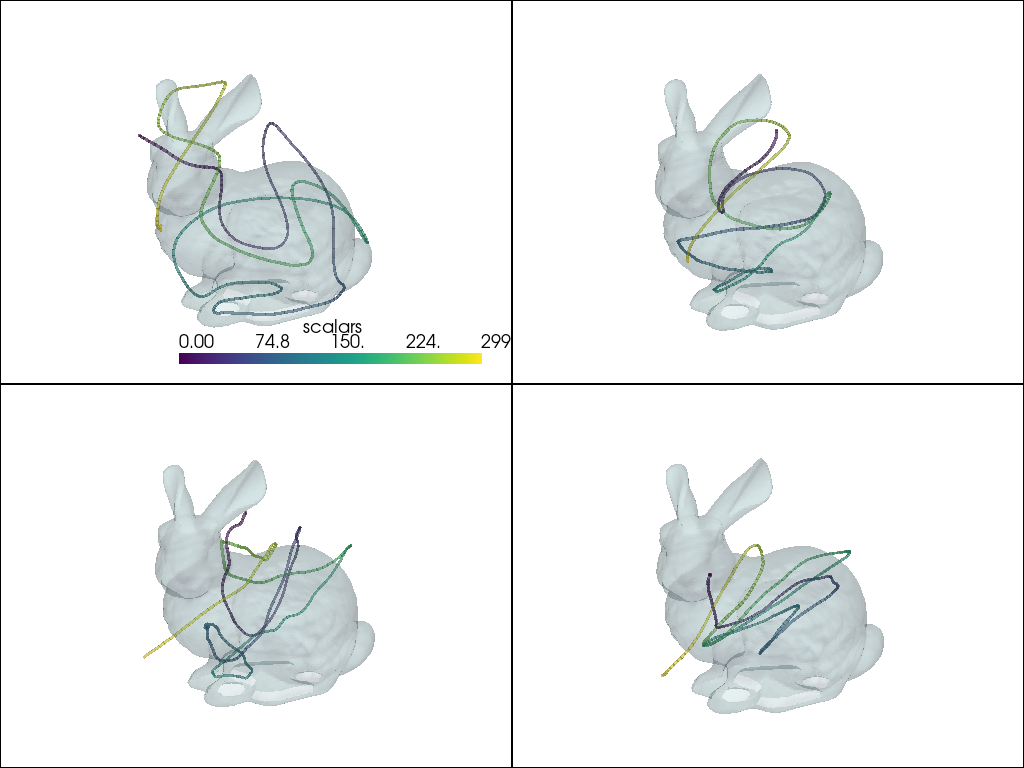

In [349]:
plot_multi_3d_traj_pv(bunny, rff_trajectories, shape=(2,2), camera_pos=bunny_camera, color=True)

### Deep Kernels

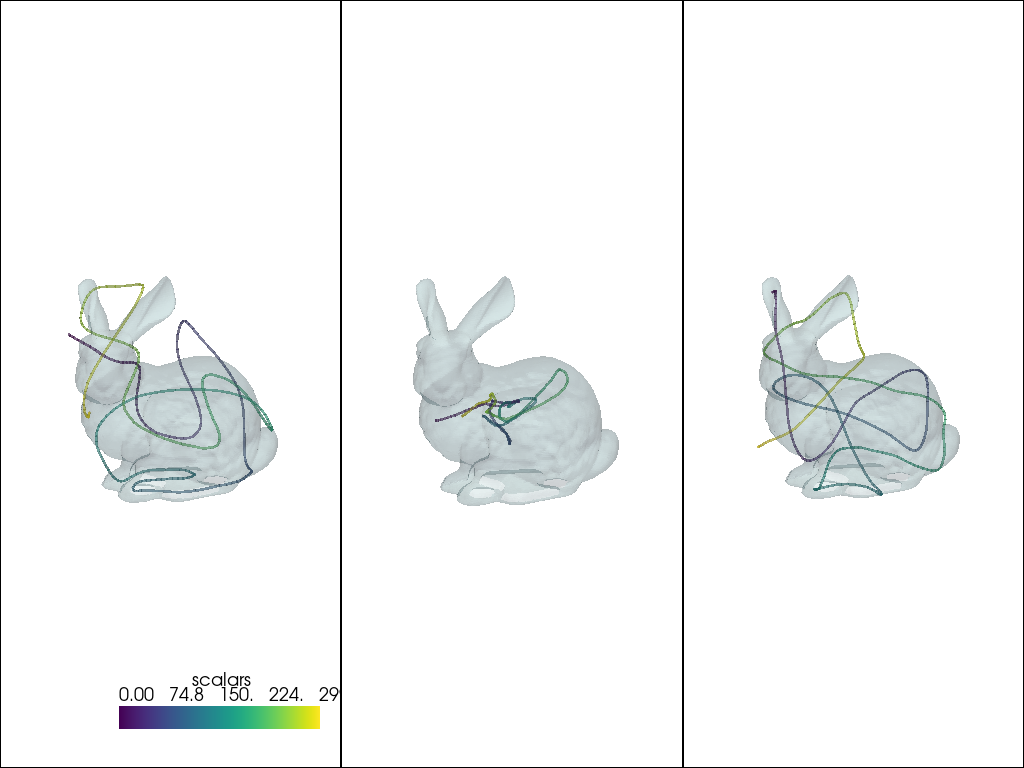

In [365]:
plot_multi_3d_traj_pv(bunny, deep_trajectories, camera_pos=bunny_camera, color=True)

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [24]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))